In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/first-dataset/sample_submission.csv
/kaggle/input/first-dataset/train.csv
/kaggle/input/first-dataset/test.csv
/kaggle/input/summer-school-hack-i/sample_submission.csv
/kaggle/input/summer-school-hack-i/train.csv
/kaggle/input/summer-school-hack-i/test.csv


In [2]:
train=pd.read_csv("/kaggle/input/summer-school-hack-i/train.csv")
test=pd.read_csv("/kaggle/input/summer-school-hack-i/test.csv")

In [3]:
print(train.head())
print(train.info())
print(train.describe())
print(train.isnull().sum())


       f1      f2      f3      f4      f5      f6      f7      f8      f9  \
0  52.843  66.492  57.300  25.224  39.213  56.593  27.157  67.453  55.690   
1  50.478  53.147  46.412  38.045  52.160  50.398  60.157  44.022  48.668   
2  16.432  30.201  43.268  76.786  58.864  24.046  46.519  63.948  50.190   
3  39.355  33.501  76.737  57.453  58.991  49.938  42.713  71.836  47.394   
4  30.337  62.905  70.896  35.969  45.878  56.114  45.075  61.684  58.865   

      f10  ...     f12     f13     f14     f15     f16     f17     f18  \
0  36.504  ...  46.375  78.489  36.789  55.797  43.135  37.513  64.094   
1  45.512  ...  61.904  46.994  35.492  55.057  43.859  54.722  51.982   
2  65.539  ...  27.011  26.714  66.842  32.628  47.996  75.920  24.627   
3  64.772  ...  44.349  45.166  85.341  32.967  26.003  40.192  41.518   
4  41.360  ...  45.491  65.265  48.155  49.756  48.782  44.316  43.562   

      f19     f20     target  
0  43.039  42.852  148.76994  
1  43.310  46.613  152.01250  

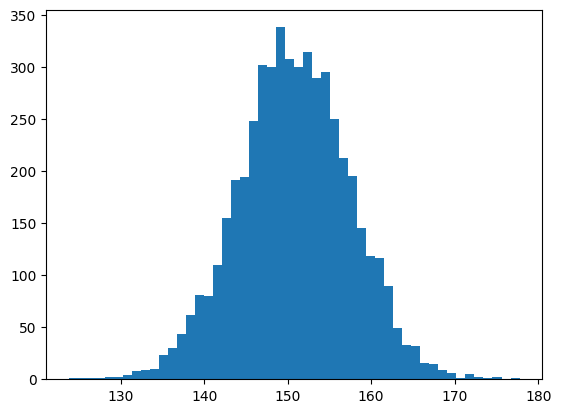

In [4]:
import matplotlib.pyplot as plt
plt.hist(train['target'], bins=50)  # replace 'target_column' with your actual target
plt.show()


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

X = train.drop(columns=['target'])  # features
y = train['target']                   # target

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_valid)
print("Validation R2 score:", r2_score(y_valid, y_pred))


Validation R2 score: 0.34504201400834666


In [6]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_rf_pred = rf.predict(X_valid)
print("Random Forest Validation R2:", r2_score(y_valid, y_rf_pred))


Random Forest Validation R2: 0.34504201400834666


Check Feature Importance

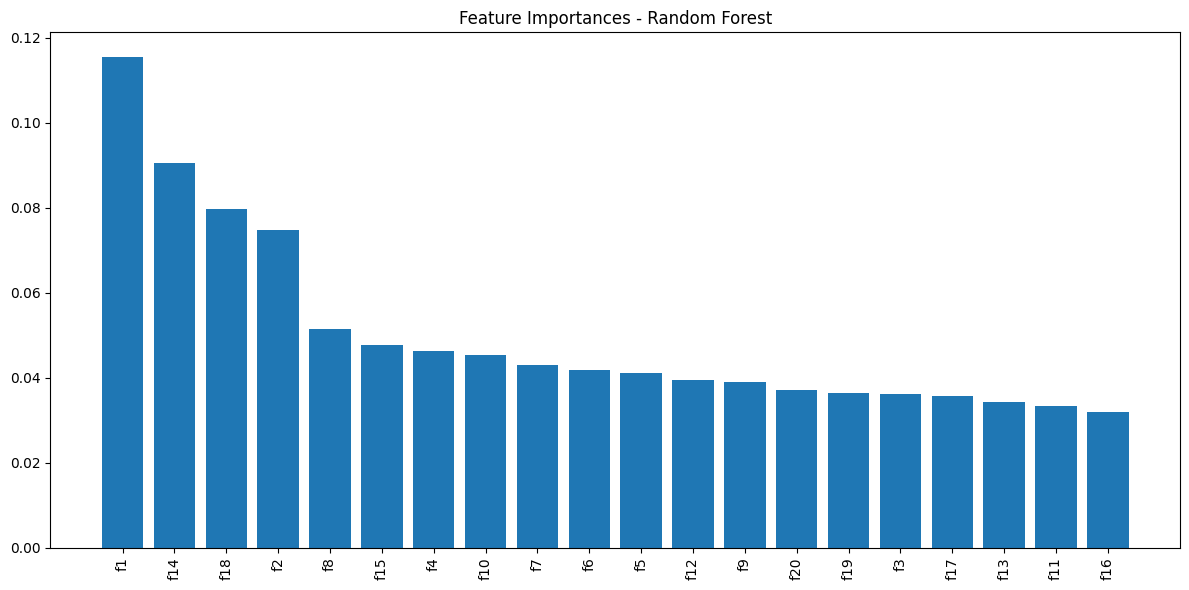

In [7]:
import matplotlib.pyplot as plt
import numpy as np

importances = rf.feature_importances_
features = X.columns

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12,6))
plt.title("Feature Importances - Random Forest")
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), features[indices], rotation=90)
plt.tight_layout()
plt.show()


In [8]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Use all features again since top-15 didn't improve
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestRegressor(random_state=42)

random_search = RandomizedSearchCV(rf, param_distributions=param_dist,
                                   n_iter=25, cv=3, verbose=2, random_state=42, n_jobs=-1)

random_search.fit(X_train, y_train)

best_rf = random_search.best_estimator_

y_pred = best_rf.predict(X_valid)
print("Tuned Random Forest Validation R2:", r2_score(y_valid, y_pred))


Fitting 3 folds for each of 25 candidates, totalling 75 fits
Tuned Random Forest Validation R2: 0.3359198325690529


In [9]:
from sklearn.model_selection import cross_val_score
rf = RandomForestRegressor(**random_search.best_params_, random_state=42)

scores = cross_val_score(rf, X, y, cv=5, scoring='r2')
print("Cross-validated R2 scores:", scores)
print("Mean CV R2:", scores.mean())


Cross-validated R2 scores: [0.33079112 0.32792123 0.2964773  0.35300417 0.29997035]
Mean CV R2: 0.3216328344125303


In [10]:
import lightgbm as lgb
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# Split data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid)

# Parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

# Use callbacks for early stopping and logging
callbacks = [
    lgb.early_stopping(stopping_rounds=50),
    lgb.log_evaluation(period=50)
]

# Train model
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, valid_data],
    valid_names=['train', 'valid'],
    num_boost_round=1000,
    callbacks=callbacks
)

# Predict and evaluate
y_pred = model.predict(X_valid, num_iteration=model.best_iteration)
print("LightGBM Validation R2:", r2_score(y_valid, y_pred))


Training until validation scores don't improve for 50 rounds
[50]	train's rmse: 4.8661	valid's rmse: 5.305
[100]	train's rmse: 4.14849	valid's rmse: 5.07642
[150]	train's rmse: 3.6572	valid's rmse: 5.02554
[200]	train's rmse: 3.26084	valid's rmse: 4.99488
[250]	train's rmse: 2.92678	valid's rmse: 4.97834
[300]	train's rmse: 2.63715	valid's rmse: 4.98235
Early stopping, best iteration is:
[250]	train's rmse: 2.92678	valid's rmse: 4.97834
LightGBM Validation R2: 0.40921083839809913


In [11]:
from catboost import CatBoostRegressor

model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    loss_function='RMSE',
    early_stopping_rounds=50,
    verbose=100
)
model.fit(X_train, y_train, eval_set=(X_valid, y_valid))
y_pred = model.predict(X_valid)
print("CatBoost R2:", r2_score(y_valid, y_pred))


0:	learn: 6.7037444	test: 6.4507661	best: 6.4507661 (0)	total: 58.1ms	remaining: 58s
100:	learn: 5.4774159	test: 5.4950867	best: 5.4950867 (100)	total: 387ms	remaining: 3.44s
200:	learn: 5.0811617	test: 5.2782164	best: 5.2779946 (199)	total: 711ms	remaining: 2.83s
300:	learn: 4.6955088	test: 5.1486320	best: 5.1486320 (300)	total: 1.03s	remaining: 2.4s
400:	learn: 4.3806891	test: 5.0799678	best: 5.0792737 (398)	total: 1.35s	remaining: 2.02s
500:	learn: 4.1088884	test: 5.0318930	best: 5.0318930 (500)	total: 1.68s	remaining: 1.67s
600:	learn: 3.8659208	test: 5.0080110	best: 5.0080110 (600)	total: 2s	remaining: 1.33s
700:	learn: 3.6425697	test: 4.9878819	best: 4.9878819 (700)	total: 2.33s	remaining: 993ms
800:	learn: 3.4401952	test: 4.9772002	best: 4.9772002 (800)	total: 2.65s	remaining: 659ms
900:	learn: 3.2460549	test: 4.9739928	best: 4.9721489 (872)	total: 2.98s	remaining: 328ms
999:	learn: 3.0683868	test: 4.9564197	best: 4.9564197 (999)	total: 3.31s	remaining: 0us

bestTest = 4.9564197

In [12]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Load data
X = train.drop(columns=['target'])
y = train['target']

# Feature Engineering
X['row_mean'] = X.mean(axis=1)
X['row_std'] = X.std(axis=1)
X['row_max'] = X.max(axis=1)
X['row_min'] = X.min(axis=1)
X['row_range'] = X['row_max'] - X['row_min']

# Train-validation split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid)

# Parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'random_state': 42
}

# Training
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, valid_data],
    valid_names=['train', 'valid'],
    num_boost_round=1000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=50)
    ]
)

# Prediction and Evaluation
y_pred = model.predict(X_valid, num_iteration=model.best_iteration)
print("LightGBM Validation R2 with feature engineering:", r2_score(y_valid, y_pred))


Training until validation scores don't improve for 50 rounds
[50]	train's rmse: 4.64226	valid's rmse: 5.15941
[100]	train's rmse: 3.93122	valid's rmse: 4.96798
[150]	train's rmse: 3.43076	valid's rmse: 4.90059
[200]	train's rmse: 3.0314	valid's rmse: 4.8734
[250]	train's rmse: 2.69365	valid's rmse: 4.84962
Early stopping, best iteration is:
[239]	train's rmse: 2.76226	valid's rmse: 4.84616
LightGBM Validation R2 with feature engineering: 0.44016539694931933


In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

X = train.drop(columns=["target"])
y = train["target"]
X_test = test.drop(columns=["id"])

# Feature engineering
for df in [X, X_test]:
    df["row_mean"] = df.mean(axis=1)
    df["row_std"] = df.std(axis=1)
    df["row_max"] = df.max(axis=1)
    df["row_min"] = df.min(axis=1)
    df["row_range"] = df["row_max"] - df["row_min"]

# K-Fold stacking setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)
oof_preds = np.zeros((X.shape[0], 3))
test_preds = np.zeros((X_test.shape[0], 3))

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

    lgb = LGBMRegressor(num_leaves=20, max_depth=10, learning_rate=0.05,
                        n_estimators=200, subsample=0.8, colsample_bytree=0.8, random_state=42)
    cat = CatBoostRegressor(iterations=1000, learning_rate=0.05, depth=6,
                            loss_function='RMSE', early_stopping_rounds=50, verbose=0, random_state=42)
    rf = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1)

    lgb.fit(X_tr, y_tr)
    cat.fit(X_tr, y_tr, eval_set=(X_val, y_val))
    rf.fit(X_tr, y_tr)

    oof_preds[val_idx, 0] = lgb.predict(X_val)
    oof_preds[val_idx, 1] = cat.predict(X_val)
    oof_preds[val_idx, 2] = rf.predict(X_val)

    test_preds[:, 0] += lgb.predict(X_test) / 5
    test_preds[:, 1] += cat.predict(X_test) / 5
    test_preds[:, 2] += rf.predict(X_test) / 5

# Train XGBoost meta-model
meta = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=3, random_state=42)
meta.fit(oof_preds, y)
final_test_pred = meta.predict(test_preds)

# Evaluate OOF R2
print("Final OOF R2:", r2_score(y, meta.predict(oof_preds)))

# Save submission
submission = pd.DataFrame({
    "id": test["id"],
    "target": final_test_pred
})
submission.to_csv("submission_kfold_stack.csv", index=False)
print("✅ submission_kfold_stack.csv saved!")


Final OOF R2: 0.47960563001360235
✅ submission_kfold_stack.csv saved!
